## Task 1

First Step was downloading & preparing the dataset. I found a pretty interesting image recognition set called the "architectural heritage elements image dataset" I decided to use. Unfortunately most the links to the set were broken or otherwise hard-to-reach so I was only able to gather the 7,174 images used in the Training data. This turned out to be fine since I just used a couple python programs to move the images into 3 seperate folders in preperation. The dataset was configured like this:

The dataset held 3 folders, test (10%), train (81%), val (9%). Each holding a percentage of the total 7k images I had. From there, each folder has 10 class folders: altar, apse, bell_tower, column, dome(inner), dome(outer), flying_buttress, gargoyle, stained_glass, and vault.

The class folders were where the .jpgs were stored. Here are examples of altars, columns, flying_buttresses, and stained_glasses ![altars, columns, flying_buttresses, and stained_glasses](examples.png)

The dataset is incredibly diverse in a lot of ways and I can see the CNN getting tripped trying to distinguish different architectures. Each picture is 150x150 pixels and in RGB. Unfortunately, the input for most popular CNN architectures is either 224x224 or 227x227, so first thing I gotta do is resize and collect all the images.

In [110]:
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Paths to dataset folders
train_path="dataset/train"
test_path="dataset/test"
val_path="dataset/val"

# initialize empty arrays
y_train=[]
x_train=[]
y_test=[]
x_test=[]
y_val=[]
x_val=[]

# Class variable
clss = 0

# for each class folder
for folder in os.listdir(train_path):
    # get class path
    class_path=train_path+"/"+folder
    
    # for each image in class path
    for img in os.listdir(class_path):

        # get image path
        image_path=class_path+"/"+img
        
        # read image into array
        img_arr=cv2.imread(image_path)
        
        # important: some images were not readable
        # due to unrecognizable characters used in the name
        # of the image (e.g. spanish characters i think?)
        # so check if the image was read at all.
        if img_arr is not None:
            
            # resize to 227x227
            img_arr=cv2.resize(img_arr,(227,227))
            
            # add to x_train, y_train
            x_train.append(img_arr)
            y_train.append(clss)
    
    # once finished reading images in class
    # increment class value
    clss += 1
            
# Repeat process for test
clss = 0     
for folder in os.listdir(test_path):
    class_path=test_path+"/"+folder
    for img in os.listdir(class_path):
        image_path=class_path+"/"+img
        img_arr=cv2.imread(image_path)
        if img_arr is not None:
            img_arr=cv2.resize(img_arr,(227,227))
            x_test.append(img_arr)
            y_test.append(clss)
    clss += 1

# Repeat process for validation
clss = 0    
for folder in os.listdir(val_path):
    class_path=val_path+"/"+folder
    for img in os.listdir(class_path):
        image_path=class_path+"/"+img
        img_arr=cv2.imread(image_path)
        if img_arr is not None:
            img_arr=cv2.resize(img_arr,(227,227))
            x_val.append(img_arr)
            y_val.append(clss)
    clss += 1

# Everything to numpy array
y_train=np.array(y_train)
x_train=np.array(x_train)
y_test=np.array(y_test)
x_test=np.array(x_test)
y_val=np.array(y_val)
x_val=np.array(x_val)
    
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)
print(y_val.shape)
print(x_val.shape)

(8191,)
(8191, 227, 227, 3)
(1019,)
(1019, 227, 227, 3)
(914,)
(914, 227, 227, 3)


Next step is to normalize the image values from 0-255 to 0-1. After which I'll show the model I created!

In [111]:
# Normalize x values
x_train=x_train/255.0
x_test=x_test/255.0
x_val=x_val/255.0

# My model!
model = keras.models.Sequential([
    keras.Input((227, 227, 3)),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(254, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_15 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_16 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                     

My model is based on the Alexnet architecture, with a couple of corners cut. Most obvious is the fact that alexnet has about 60 million parameters while I cut it down to 18 million by reducing the second to last dense layer's number of neurons significantly.

Also, I've only got 3 convolutional layers instead of 5. Lastly, I have 2 max pooling layers instead of 3.

I based my architecture off of Alexnet because that is one of the most popular structures in the CNN scene, so I know it'd do well with the dataset. Only issue is I greatly simplified it, meaning it might struggle a bit. I had to simplify it in order to reduce the time it took to train though.

In [4]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics='accuracy')

# Run 10 epochs with batch size 100
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=100,shuffle=True)

Epoch 1/10
82/82 [==============================] - 262s 3s/step - loss: 11.1500 - accuracy: 0.2356 - val_loss: 2.2635 - val_accuracy: 0.1641
Epoch 2/10
82/82 [==============================] - 290s 4s/step - loss: 2.1076 - accuracy: 0.2698 - val_loss: 2.1020 - val_accuracy: 0.2681
Epoch 3/10
82/82 [==============================] - 265s 3s/step - loss: 1.9407 - accuracy: 0.3063 - val_loss: 1.8404 - val_accuracy: 0.3020
Epoch 4/10
82/82 [==============================] - 257s 3s/step - loss: 1.8901 - accuracy: 0.3238 - val_loss: 1.9909 - val_accuracy: 0.3490
Epoch 5/10
82/82 [==============================] - 263s 3s/step - loss: 1.8897 - accuracy: 0.3344 - val_loss: 1.7957 - val_accuracy: 0.3370
Epoch 6/10
82/82 [==============================] - 261s 3s/step - loss: 1.7908 - accuracy: 0.3636 - val_loss: 3.2761 - val_accuracy: 0.3621
Epoch 7/10
82/82 [==============================] - 253s 3s/step - loss: 1.7394 - accuracy: 0.3805 - val_loss: 1.7431 - val_accuracy: 0.4300
Epoch 8/10
8

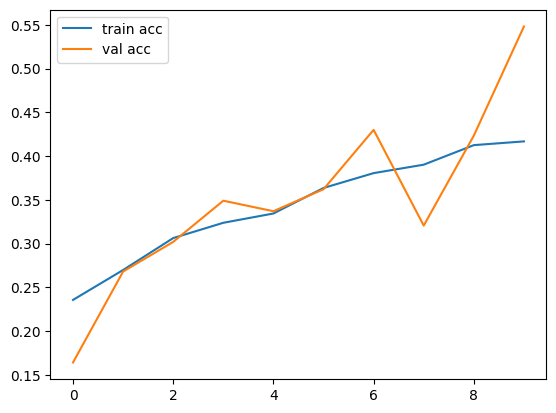

In [5]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [7]:
model.evaluate(x_test,y_test,batch_size=100)

11/11 [==============================] - 14s 1s/step - loss: 1.4408 - accuracy: 0.5417


[1.4408419132232666, 0.5417075753211975]

The model was able to get an impressive 54% accuracy in the test and validation sets! To be completely honest I was expecting around 30-35% accuracy, but Alexnet lives up to it's name. I'd assume if we used the real architecture and went for 15 epochs we'd see around 70% accuracy.

## Part 2

For part 2, I wanted to compare my makeshift Alexnet architecture to the MobileNetv2 Architecture. From what I understand, MobileNetv2 uses Bottleneck Layers and Depthwise convolutions. Both of which are methods of learning which aim to speed up the learning process while remaining competitive to traditional architectures of similar layer size.

In [13]:
MNv2 = keras.applications.MobileNetV2(
    input_shape=(227, 227, 3),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=max,
    classes=10,
    classifier_activation="softmax",
)
MNv2.summary()

Model: "mobilenetv2_1.00_227"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 114, 114, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 114, 114, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 57, 57, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 59, 59, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 29, 29, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 29, 29, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 15, 15, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 15, 15, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 15, 15, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 15, 15, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 15, 15, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 15, 15, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 15, 15, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 15, 15, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

It should be noted MobileNetv2 has 2 million parameters, an insanely small amount compared to mine! WOW!!! SERIOUSLY!!!!

In [9]:
MNv2.compile( loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Same parameters as the other model
history = MNv2.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10,batch_size=100,shuffle=True)

Epoch 1/10
82/82 [==============================] - 594s 7s/step - loss: 1.3777 - accuracy: 0.5161 - val_loss: 2.2944 - val_accuracy: 0.1554
Epoch 2/10
82/82 [==============================] - 565s 7s/step - loss: 0.8924 - accuracy: 0.6889 - val_loss: 2.3274 - val_accuracy: 0.1554
Epoch 3/10
82/82 [==============================] - 545s 7s/step - loss: 0.7041 - accuracy: 0.7577 - val_loss: 2.4008 - val_accuracy: 0.1094
Epoch 4/10
82/82 [==============================] - 551s 7s/step - loss: 0.5936 - accuracy: 0.7921 - val_loss: 2.5401 - val_accuracy: 0.1094
Epoch 5/10
82/82 [==============================] - 514s 6s/step - loss: 0.4793 - accuracy: 0.8358 - val_loss: 2.6406 - val_accuracy: 0.1554
Epoch 6/10
82/82 [==============================] - 538s 7s/step - loss: 0.4242 - accuracy: 0.8591 - val_loss: 2.8400 - val_accuracy: 0.1554
Epoch 7/10
82/82 [==============================] - 555s 7s/step - loss: 0.3472 - accuracy: 0.8794 - val_loss: 3.0616 - val_accuracy: 0.1554
Epoch 8/10
82

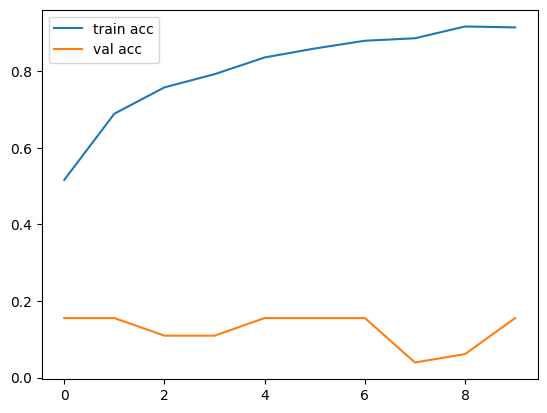

In [10]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [12]:
MNv2.evaluate(x_test,y_test,batch_size=100)

11/11 [==============================] - 11s 1s/step - loss: 3.7211 - accuracy: 0.1551


[3.7210512161254883, 0.155053973197937]

MobilenetV2 did an incredible job in training, but failed to gain accuracy out of training. This is almost entirely my fault as I had ZERO regularization (e.g early stopping) and so MNv2 just overfit like crazy. Also, I could just run it off the pre-trained values and get much better accuracy.

## Part 3

The final part is to do some data augmentation and repeat the process of part 1. I believe image rotation would not work. Certain classes like vault and bell tower rely heavily on the shape of the architecture in the image and the fact the pictures were taken upright. On the other hand, perhaps flipping all the images on the vertical axis would do some good!

In [16]:
y_train_edit = np.concatenate((y_train,y_train),axis=None)
x_flipped = []
for img in x_train:
    x_flipped.append(np.fliplr(img))

x_flipped = np.array(x_flipped)
x_train_edit = np.concatenate((x_train,x_flipped),axis=0)

print(x_train_edit.shape)
print(y_train_edit.shape)

(16382, 227, 227, 3)
(16382,)


In [19]:
aug = keras.models.Sequential([
    keras.Input((227, 227, 3)),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(254, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
# same as model, just named 'aug'

In [20]:
aug.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics='accuracy')

# Run 10 epochs with batch size 100
history = aug.fit(x_train_edit,y_train_edit,validation_data=(x_val,y_val),epochs=10,batch_size=100,shuffle=True)

Epoch 1/10
164/164 [==============================] - 534s 3s/step - loss: 5.9885 - accuracy: 0.2486 - val_loss: 2.0842 - val_accuracy: 0.2560
Epoch 2/10
164/164 [==============================] - 503s 3s/step - loss: 1.9648 - accuracy: 0.3246 - val_loss: 2.4669 - val_accuracy: 0.3435
Epoch 3/10
164/164 [==============================] - 509s 3s/step - loss: 1.8112 - accuracy: 0.3768 - val_loss: 1.5741 - val_accuracy: 0.5153
Epoch 4/10
164/164 [==============================] - 514s 3s/step - loss: 1.7075 - accuracy: 0.4022 - val_loss: 20.6180 - val_accuracy: 0.1772
Epoch 5/10
164/164 [==============================] - 501s 3s/step - loss: 1.6344 - accuracy: 0.4239 - val_loss: 2.2280 - val_accuracy: 0.4179
Epoch 6/10
164/164 [==============================] - 515s 3s/step - loss: 1.5756 - accuracy: 0.4360 - val_loss: 7.4509 - val_accuracy: 0.2188
Epoch 7/10
164/164 [==============================] - 506s 3s/step - loss: 1.5031 - accuracy: 0.4603 - val_loss: 3.1960 - val_accuracy: 0.375

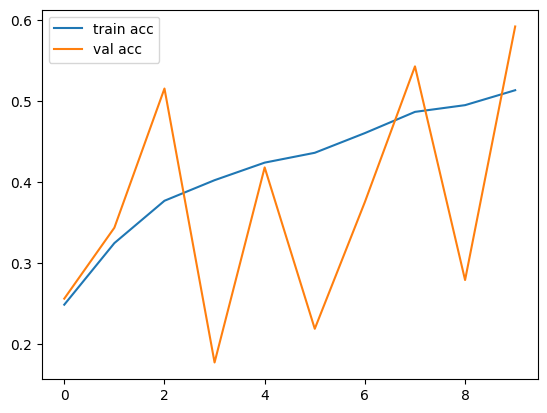

In [21]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [22]:
aug.evaluate(x_test,y_test,batch_size=100)

11/11 [==============================] - 12s 1s/step - loss: 1.3151 - accuracy: 0.5957


[1.3150575160980225, 0.5956820249557495]

The augmentation did lots to assisting the development of in-train accuracy. I mean, you got 2x the number of data points to test against! Plus, the final test accuracy is 59.6%! While this is better than previous, I'm actually more worried because the validation accuracy fluctuated so crazily.

# Task 2

For part 2, let's try generating some images using the data we've got. I read up on the VAE and it should work fine on my set if I just replace mentions of MNIST with my data. That being said, the size of my dataset is TINY compared to MNIST

We can use the CVAE class written in the tutorial, although some changes need to be made (input shape, output, dimensions)

Also, 227x227 is not gonna get encoded and decoded here. I gotta resize to 224x224

In [112]:
x_resized_train=[]
for img in x_train:
    res = cv2.resize(img, (224, 224))
    x_resized_train.append(res)
                          
x_resized_train = np.array(x_resized_train)
                           
x_resized_test=[]
for img in x_test:
    res = cv2.resize(img, (224, 224))
    x_resized_test.append(res)
                          
x_resized_test = np.array(x_resized_test)
                          
print(x_resized_train.shape)
print(x_resized_test.shape)

(8191, 224, 224, 3)
(1019, 224, 224, 3)


In [60]:
import tensorflow as tf

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=56*56*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(56, 56, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [61]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [62]:
epochs = 10
batch_size = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [63]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [69]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_resized_train.astype(np.float32))
                 .shuffle(8191).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_resized_test.astype(np.float32))
                .shuffle(1019).batch(batch_size))

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -95456.296875, time elapse for current epoch: 301.4723732471466


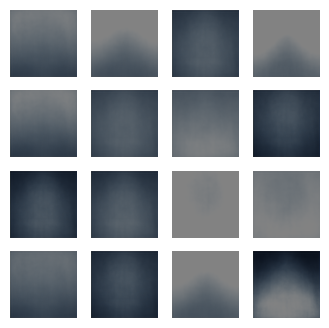

In [72]:
from IPython import display
import time

tf.config.run_functions_eagerly(True)

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Well I finally managed to get some images generated. Unfortunately those images are weird shadowy shapes in blue mist. Even still, it's interesting to see anything got generated. Also weird that blue was the most common color.

Now it's time to try GANs

In [115]:
import tensorflow as tf
# ran out of space, gotta delete some things
dir()
del x_resized_test
del x_rtrain_norm
del x_test
del x_train
del x_val
del y_test
del y_train
del y_val

In [116]:
# Change norm from 0 to 1 to -1 to 1
x_rtrain_norm = (x_resized_train - 0.5) * 2

train_ds = (tf.data.Dataset.from_tensor_slices(x_rtrain_norm.astype(np.float32)).shuffle(8191).batch(256))

In [117]:
# Generator model (224x224x3) output
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(56*56*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((56, 56, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [118]:
# Discriminator model (224x224x3) Input
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[224, 224, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())

    return model

In [119]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [120]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Adam optimizer again?! Im a big fan
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [121]:
EPOCHS = 10
BATCH_SIZE = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [122]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [127]:
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    gs_images_GAN(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  gs_images_GAN(generator,
                           epochs,
                           seed)

In [128]:
# Should rename function due to VAE using name already
def gs_images_GAN(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

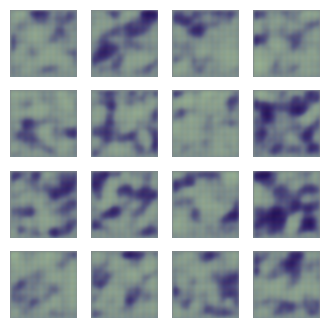

Time for epoch 3 is 1044.3537123203278 sec


KeyboardInterrupt: 

In [130]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

train(train_ds, EPOCHS)

I had to stop this early since it was taking 17 minutes to run an epoch, but three epochs in 